# Space charge fields of a relativistic electron beam 

Here is a test of the account for the space-charge fields of a relativistic electron beam. We compare 
- the particle tracker code OCELOT (<https://github.com/iagapov/ocelot/>), where the Poisson equation is solverd in a beam rest frame via FFT technique

with CHIMERA, where two modes of space-charge modeling are avaliable 

- full PIC modeling with quasi-cylindrical PSATD solver
- space-charge kicker, where relativistic Maxwell equations are solved in static approximation via FFT+DHT technique


In [1]:
%matplotlib inline
import numpy as np
from scipy.constants import e
import matplotlib.pyplot as plt
import sys

import ocelot as oclt

from chimera.moduls.species import Specie
from chimera.moduls.solvers import Solver
from chimera.moduls.chimera_main import ChimeraRun
from chimera.moduls.diagnostics import Diagnostics
from chimera.moduls import fimera as chimera

initializing ocelot...


As a simplest test, we consider a 20 $\mu$m drift of a 30 pC electron beam with the gaussian density profiles $\sigma_z=\sigma_r=3$ $\mu$m, with the longitudinal momentum $p_z=50\, m_e c $. Initially beam has no energy spread and zero divergence.

In [2]:
SimLgth = 20.
pz0 = 50.
Chrg = 30e-12
Size = 3.

nmax = Chrg/e/((Size*1.e-4)**3*(2*np.pi)**1.5)/(1.1e21)

## OCELOT simulation

In [3]:
Np = int(1e6)
BeamCharge = Chrg
parts0 = np.zeros((6,Np))

parts0[0] = Size*1e-6*np.random.randn(Np)
parts0[2] = Size*1e-6*np.random.randn(Np)
parts0[4] = Size*1e-6*np.random.randn(Np)
p_array_init = oclt.ParticleArray()
p_array_init.particles = parts0.T.flatten()
p_array_init.E = (1+pz0**2)**.5*0.511e-3
p_array_init.s = 0.0
p_array_init.q_array = (BeamCharge/Np)*np.ones(Np)

D1  = oclt.Drift(l = SimLgth*1e-6 )
D2  = oclt.Drift(l=0)
cell = (D1,D2)

sc1 = oclt.SpaceCharge()
sc1.nmesh_xyz = [63, 63, 63]
sc1.low_order_kick = False
sc1.step = 1

method = oclt.MethodTM()
lat = oclt.MagneticLattice(cell,method=method)
print("length of the cell: ", lat.totalLen, "m")

navi = oclt.Navigator(lat)
navi.add_physics_proc(sc1,lat.sequence[0],lat.sequence[-1])
p_array = oclt.deepcopy(p_array_init)

dz = 1e-6
LL = p_array.s
SS  = []
Sx  = []
Sy  = []
Sz  = []
Ex = []
Ey = []

while LL<lat.totalLen:
    oclt.tracking_step(lat, p_array, dz,navi)
    proc_list = navi.get_proc_list()
    for p in proc_list:
        p.z0 = navi.z0
        p.apply(p_array, dz)
    LL += dz
    sys.stdout.write('\r'+str(LL)+'/'+str(lat.totalLen))
    sys.stdout.flush()

length of the cell:  1.9999999999999998e-05 m


/Users/igor/CODES/ocelot/cpbd/optics.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = np.add(np.transpose(dot(self.R(energy), np.transpose(particles.reshape(n/6, 6)))), self.B(energy)).reshape(n)
/Users/igor/CODES/ocelot/cpbd/sc.py:158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xxstg.shape = (npartl, 6)


2.0000000000000005e-05/1.9999999999999998e-05

## CHIMERA with solver in "StaticKick" mode

In [4]:
xmin, xmax = -7.*Size,7.*Size
lrg = 30*Size
Nx = 300
Nr = 300

dx = (xmax-xmin)/Nx
dr = lrg/Nr
dt = 1.0

solver_in = {
    'Grid':(xmin, xmax,lrg,dx,dr),'TimeStep':dt,'MaxAzimuthMode':1,
    'Features':('StaticKick',),'Xchunked':(4,6)
}

beam_in = {
    'Grid':(xmin, xmax,lrg,dx,dr),'TimeStep':dt,'Charge':-1.,'Mass':1.,
    'Density':nmax, 'FixedCell':(4,8,8),'MomentaMeans':(pz0,0.,0.),
    'Xchunked':(4,6)
}

solver = Solver(solver_in)
beam = Specie(beam_in)

MovingFrame = {'TimeStep':dt,'Steps':1,'Features':('NoSorting','Staged')}

chimera_in = {
    'Solvers':(solver,),'Particles':(beam,),'MovingFrames':(MovingFrame,)
}

fu = lambda x,y,z: np.exp(-0.5*(x**2+y**2+z**2)/Size**2)
beam.add_particles(*beam.gen_parts(Domain=(-3.5*Size,3.5*Size, 0.0, 3.5*Size),ProfileFunc=fu))

Chimera = ChimeraRun(chimera_in)
Diags = Diagnostics(Chimera,(),out_folder=None)

for i in range(int(SimLgth/dt)+1):
    Chimera.make_step(i)
    sys.stdout.write('\r'+str(i)+'/'+str(int(SimLgth/dt)))
    sys.stdout.flush()  

Constructing solver with cylindric boundaries:
    left=-21, right=21, radius=90
Spatial and temporal resolutions:
    dx=0.14, dr=0.3, dt=1
Grid resolutions are:
    Nx=304, Nr=300, Mo=2
Charge density will be considered
20/20

## CHIMERA with solver in full PIC mode

In [5]:
xmin, xmax = -7.*Size,7.*Size
lrg = 30*Size
Nx = 300
Nr = 300

dx = (xmax-xmin)/Nx
dr = lrg/Nr
dt = 0.06

solver_in1 = {
    'Grid':(xmin, xmax,lrg,dx,dr),'TimeStep':dt,'MaxAzimuthMode':1,
    'Features':('SpaceCharge',),'Xchunked':(4,6)
}

beam_in1 = {
    'Grid':(xmin, xmax,lrg,dx,dr),'TimeStep':dt,'Charge':-1.,'Mass':1.,
    'Density':nmax, 'FixedCell':(4,8,8),'MomentaMeans':(pz0,0.,0.),
    'Features':(),'Xchunked':(4,6)
}

solver1 = Solver(solver_in1)
beam1 = Specie(beam_in1)

MovingFrame = {'TimeStep':dt,'Steps':1,'Features':('NoSorting','Staged')}

chimera_in1 = {
    'Solvers':(solver1,),'Particles':(beam1,),'MovingFrames':(MovingFrame,)
}

fu = lambda x,y,z: np.exp(-0.5*(x**2+y**2+z**2)/Size**2)
beam1.add_particles(*beam1.gen_parts(Domain=(-3.5*Size,3.5*Size, 0.0, 3.5*Size),ProfileFunc=fu))

Chimera1 = ChimeraRun(chimera_in1)
Diags1 = Diagnostics(Chimera1,(),out_folder=None)

for i in range(int(SimLgth/dt)+1):
    Chimera1.make_step(i)
    sys.stdout.write('\r'+str(i)+'/'+str(int(SimLgth/dt)))
    sys.stdout.flush()

Constructing solver with cylindric boundaries:
    left=-21, right=21, radius=90
Spatial and temporal resolutions:
    dx=0.14, dr=0.3, dt=0.06
Grid resolutions are:
    Nx=304, Nr=300, Mo=2
Charge density will be considered
333/333

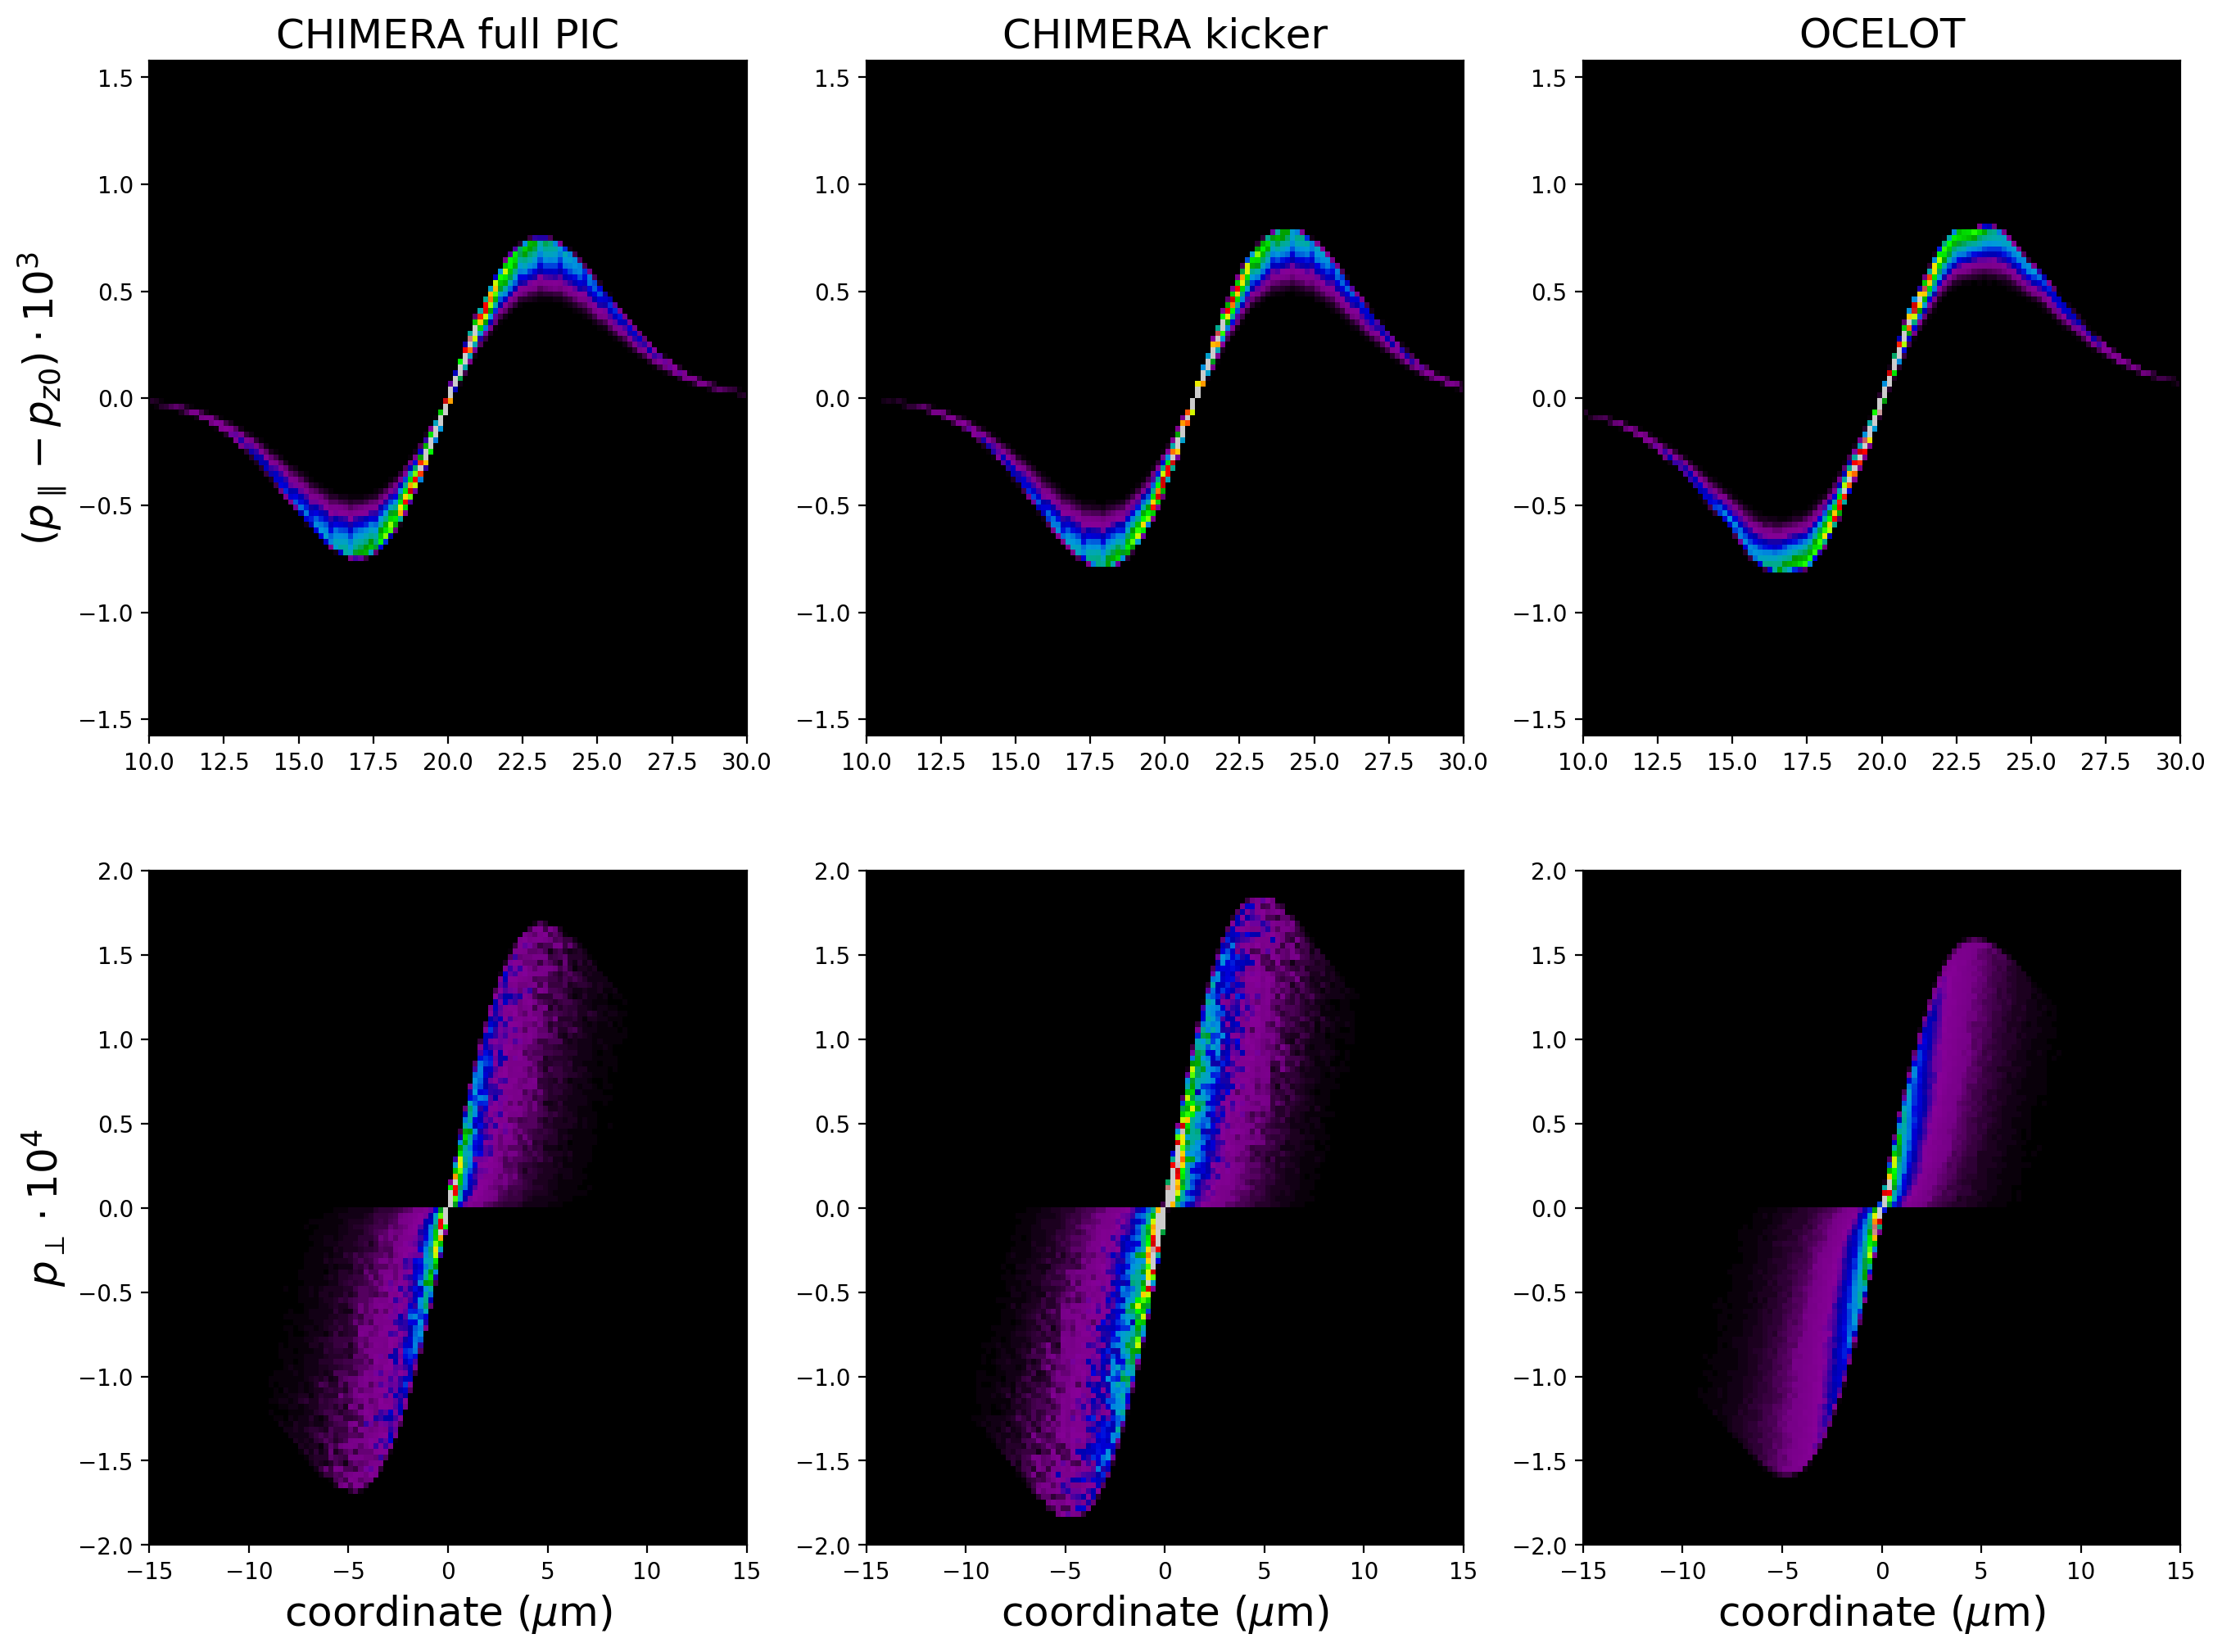

In [6]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,12),dpi=200)

dpmax = (beam.Data['momenta'][0].max()-pz0)*1e3
range1 = [[SimLgth-10,SimLgth+10],[-2*dpmax,+2*dpmax]]
range2=[[-15,15],[-2,2]]

dns_max = 1e-3

ax1.hist2d(beam1.Data['coords'][0],(beam1.Data['momenta'][0]-pz0)*1e3,weights=-beam1.Data['weights'],
           bins=120,range=range1,vmax=dns_max,cmap=plt.cm.spectral);
ax4.hist2d(beam1.Data['coords'][2],beam1.Data['momenta'][2]*1e4,weights=-beam1.Data['weights'],
           bins=120,range=range2,vmax=dns_max,cmap=plt.cm.spectral);

ax2.hist2d(beam.Data['coords'][0],(beam.Data['momenta'][0]-pz0)*1e3,weights=-beam.Data['weights'],
           bins=120,range=range1,vmax=dns_max,cmap=plt.cm.spectral);
ax5.hist2d(beam.Data['coords'][2],beam.Data['momenta'][2]*1e4,weights=-beam.Data['weights'],
           bins=120,range=range2,vmax=5e-4,cmap=plt.cm.spectral);

ax3.hist2d((-p_array.tau()+p_array.s)*1e6,(p_array.p())*p_array.E*1e6/0.511,weights=p_array.q_array,
           bins=120,range=range1,vmax=dns_max*beam.weight2pC*1e-12,cmap=plt.cm.spectral);
ax6.hist2d(p_array.x()*1e6,p_array.px()*p_array.E*1e7/0.511,weights=p_array.q_array,
           bins=120,range=range2,vmax=dns_max*beam.weight2pC*1e-12,cmap=plt.cm.spectral);

ax1.set_title('CHIMERA full PIC',fontsize=18);
ax2.set_title('CHIMERA kicker',fontsize=18)
ax3.set_title('OCELOT',fontsize=18)

for ax in (ax4,ax5,ax6): ax.set_xlabel('coordinate ($\mu$m)',fontsize=18)
ax1.set_ylabel('$(p_\parallel-p_{z0})\cdot 10^3$',fontsize=18)
ax4.set_ylabel('$p_\perp\cdot 10^4$',fontsize=18)

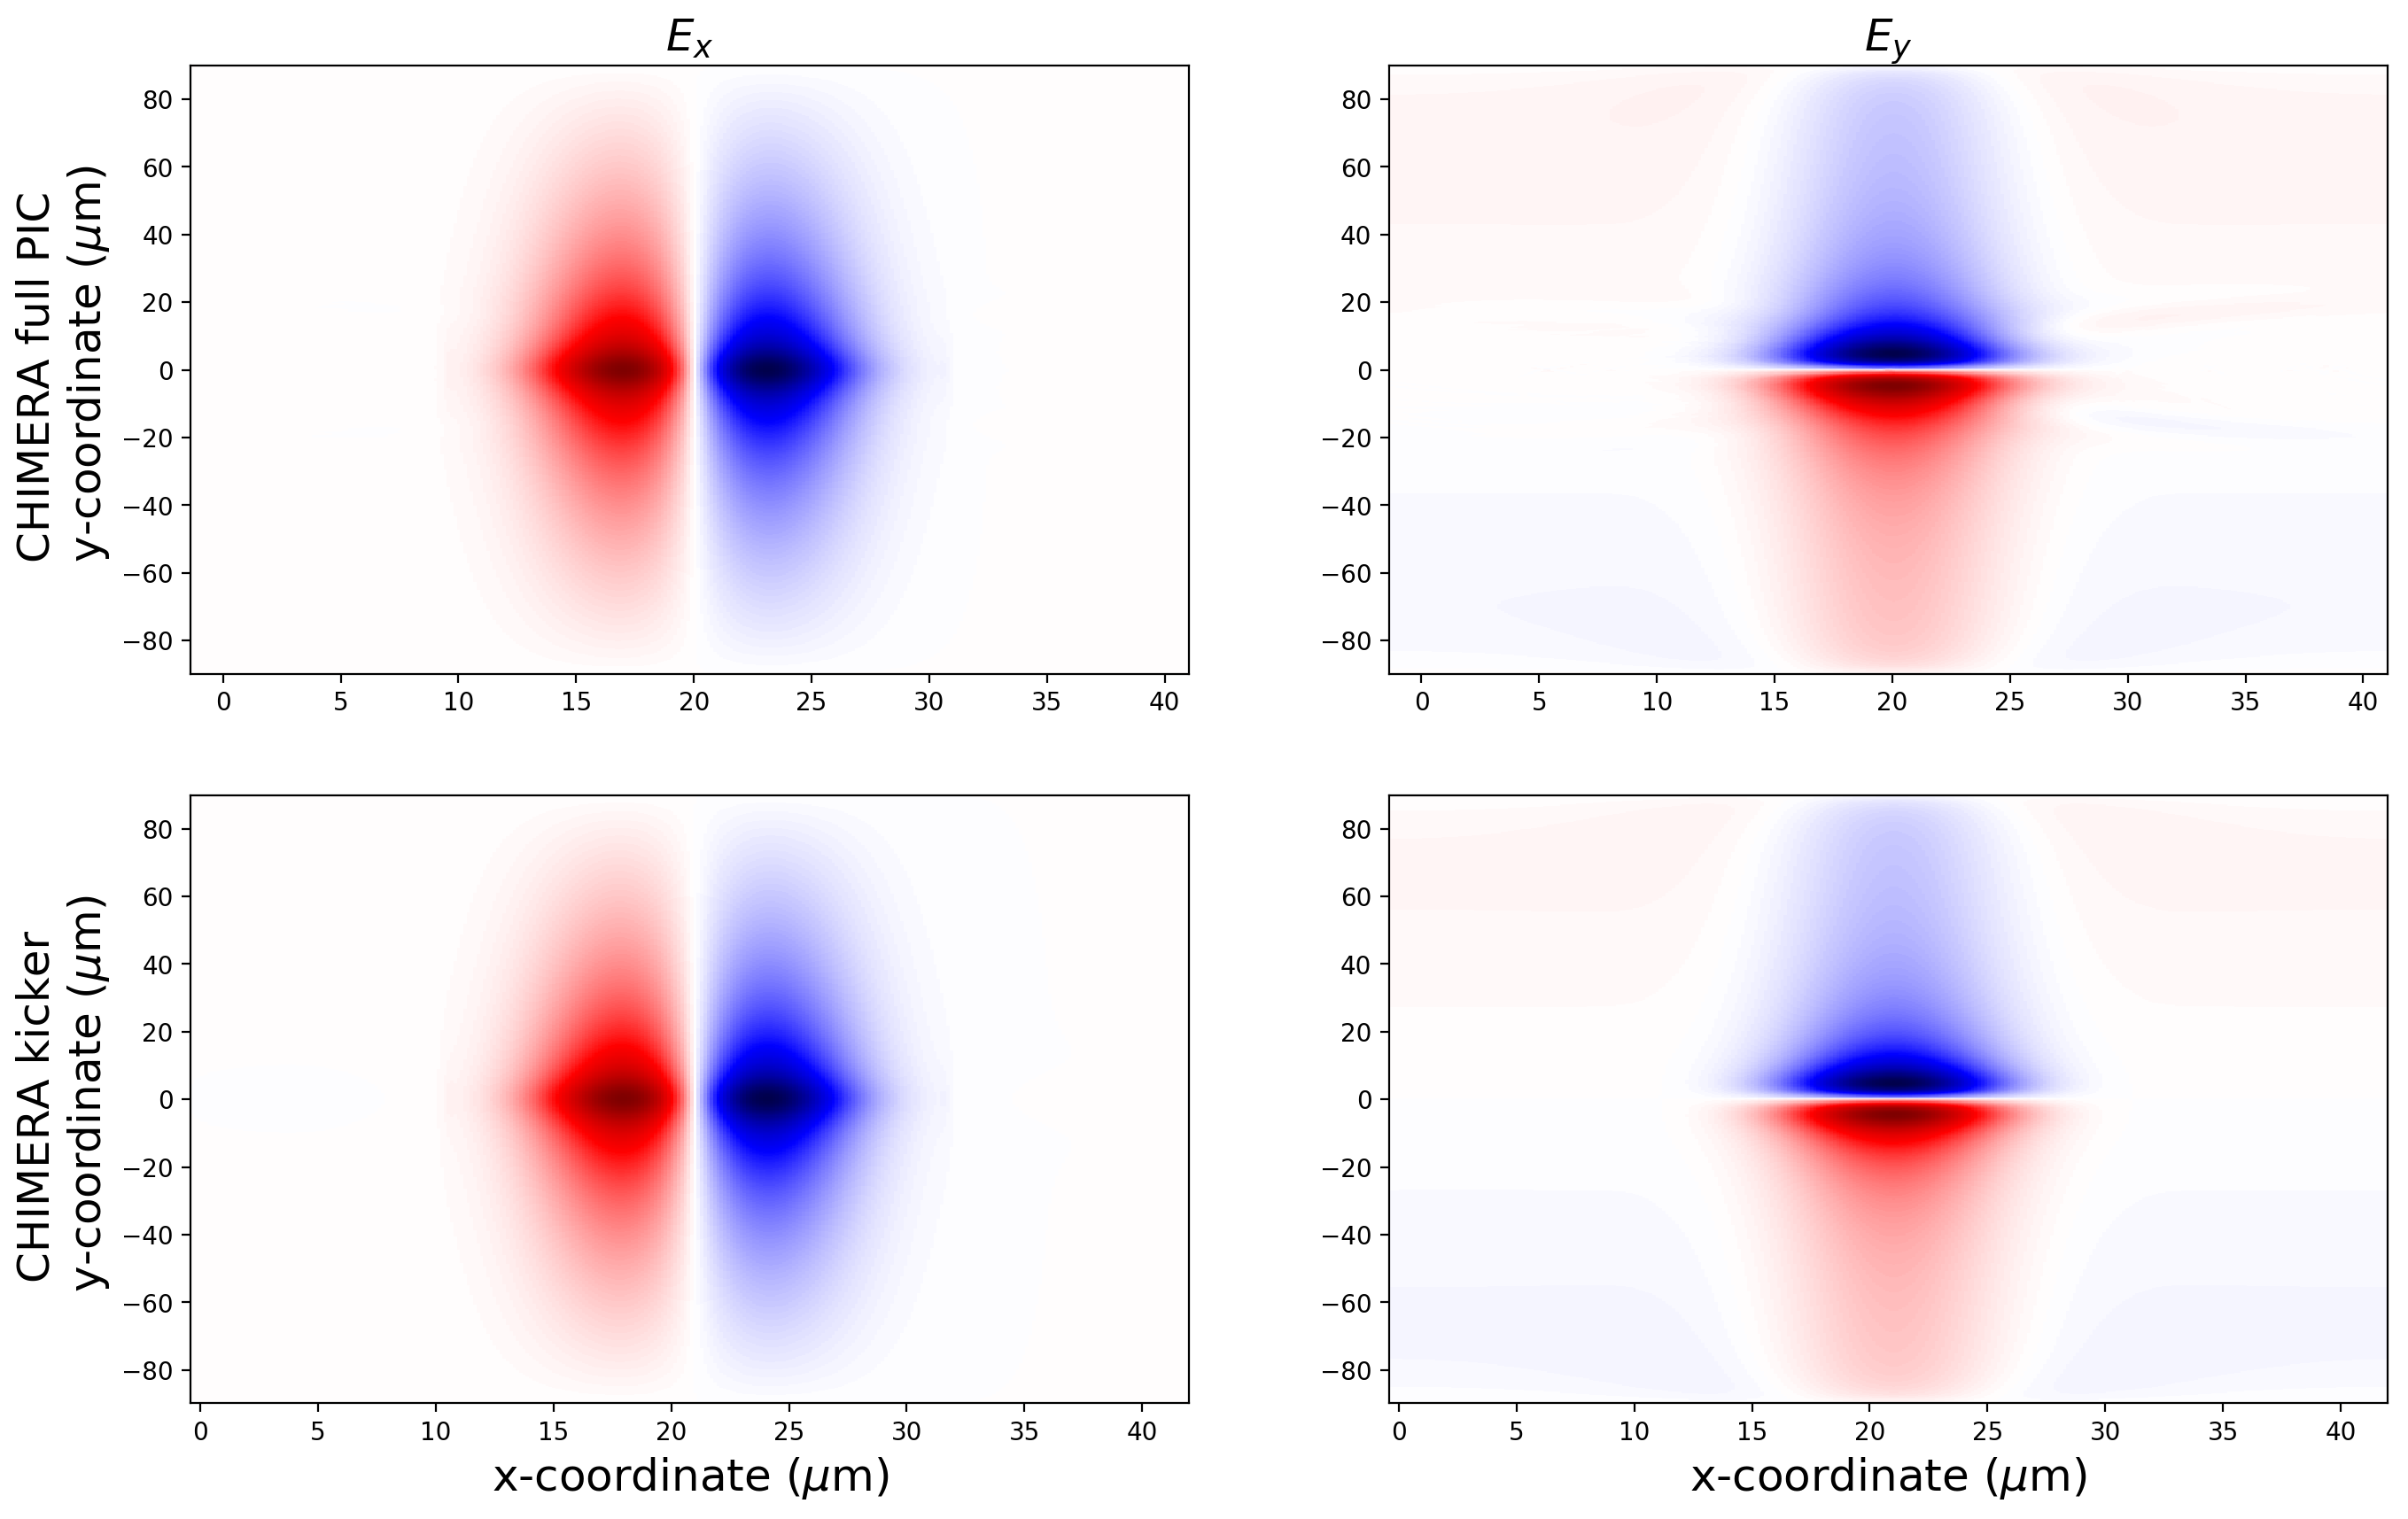

In [7]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,10),dpi=200)

extent = (solver1.Args['Xgrid'].min(),solver1.Args['Xgrid'].max(),
          -solver1.Args['Rgrid'].max(),solver1.Args['Rgrid'].max())

ee = Diags1.fld_out( {'Features':('Return',)} )[0]
nn = Diags1.dns_out( {'Features':{'Return':0,'MaxMode':1}} )[0]

ex =  np.real(np.hstack((ee[:,::-1,0,0] + ee[:,::-1,1,0],ee[:,1:,0,0] -ee[:,1:,1,0])))
ey =  np.real(np.hstack((ee[:,::-1,0,1] - ee[:,::-1,1,1],ee[:,1:,0,1] +ee[:,1:,1,1])))
bz =  np.real(np.hstack((ee[:,::-1,0,5] + ee[:,::-1,1,5],ee[:,1:,0,5] -ee[:,1:,1,5])))
ne =  np.real(np.hstack((nn[:,::-1,0] + nn[:,::-1,1],nn[:,1:,0] -nn[:,1:,1])))

pl1 = ax1.imshow(ex.T ,aspect='auto', extent=extent,origin='lower',cmap=plt.cm.seismic)
pl2 = ax2.imshow((ey+bz).T ,aspect='auto', extent=extent,origin='lower',cmap=plt.cm.seismic)

extent = (solver.Args['Xgrid'].min(),solver.Args['Xgrid'].max(),
          -solver.Args['Rgrid'].max(),solver.Args['Rgrid'].max())

ee = Diags.fld_out( {'Features':('Return',)} )[0]
nn = Diags.dns_out( {'Features':{'Return':0,'MaxMode':1}} )[0]

ex =  np.real(np.hstack((ee[:,::-1,0,0] + ee[:,::-1,1,0],ee[:,1:,0,0] -ee[:,1:,1,0])))
ey =  np.real(np.hstack((ee[:,::-1,0,1] - ee[:,::-1,1,1],ee[:,1:,0,1] +ee[:,1:,1,1])))
bz =  np.real(np.hstack((ee[:,::-1,0,5] + ee[:,::-1,1,5],ee[:,1:,0,5] -ee[:,1:,1,5])))
ne =  np.real(np.hstack((nn[:,::-1,0] + nn[:,::-1,1],nn[:,1:,0] -nn[:,1:,1])))

pl3 = ax3.imshow(ex.T ,aspect='auto', extent=extent,origin='lower',cmap=plt.cm.seismic)
pl4 = ax4.imshow((ey+bz).T ,aspect='auto', extent=extent,origin='lower',cmap=plt.cm.seismic)

#fig.colorbar(pl1,ax=ax1)
#fig.colorbar(pl2,ax=ax2)
#fig.colorbar(pl3,ax=ax3)
#fig.colorbar(pl4,ax=ax4)

ax1.set_title('$E_x$',fontsize=18);
ax2.set_title('$E_y$',fontsize=18)
for ax in (ax3,ax4,): ax.set_xlabel('x-coordinate ($\mu$m)',fontsize=18)
ax1.set_ylabel('CHIMERA full PIC \n y-coordinate ($\mu$m)',fontsize=18)
ax3.set_ylabel('CHIMERA kicker \n y-coordinate ($\mu$m)',fontsize=18)